In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# inspect further
#https://huggingface.co/spaces/merve/OWLSAM

In [10]:
import chromadb
import json
import pandas as pd
import matplotlib.pyplot as plt
from chromadb.utils.data_loaders import ImageLoader
from weavingtools.embedding_tools import SigLIPEmbedder
from weavingtools.weaving_tools import plot_query_results, get_query_results
import scipy.spatial as sp
import seaborn as sns
import numpy as np
import random
sns.set()

In [8]:
checkpoint = 'google/siglip-base-patch16-224'

siglip_embedder = SigLIPEmbedder(checkpoint)

client = chromadb.PersistentClient(path="ce_comms_db")

data_loader = ImageLoader()

collection_db = client.get_or_create_collection(name="ce_comms_db", 
                                             metadata={"hnsw:space": "cosine"},
                                             embedding_function=siglip_embedder, 
                                             data_loader=data_loader
                                            )

collection_df = pd.read_csv('data/communications_data.csv')
collection_df.shape[0], collection_db.count()

(6020, 22026)

# Segment and Search

In [4]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

In [5]:
device = "cpu" 
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [6]:
# functions taken from
def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

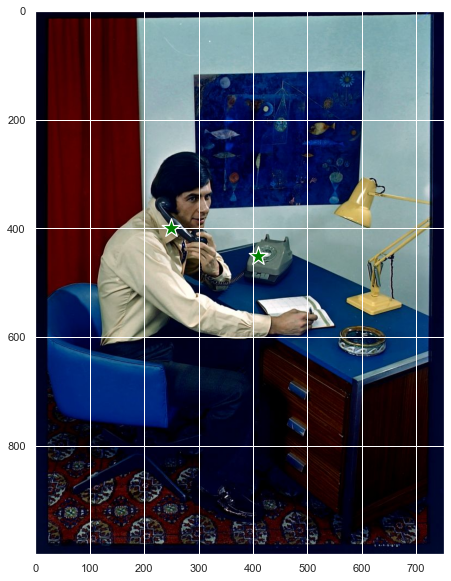

In [56]:
# # example 1
# img_url ='https://media.istockphoto.com/id/891337926/photo/beautiful-woman-with-vintage-phone.jpg?s=170667a&w=0&k=20&c=xXFnMliS5aWx4vOZIwnm6HaOW71HFCvYNTCKnO9rFRs='
# input_points = [[[300,275],[200,250],[166,200],[140,140]]]
# example 2
img_url = 'http://www.digitalarchives.bt.com/Calmview/GetImage.ashx?db=Catalog&type=default&fname=TCB_417_E54315.jpg'
input_points = [[[410,450],[250,400]]]
# # example 3
# img_url = "https://i.pinimg.com/736x/43/32/18/433218ccd63087a6ba0c66336777a8cb.jpg"
# input_points = [[[420, 550]]] # 2D location of a window in the image
# # example 4
# img_url = "https://i.pinimg.com/originals/98/8c/2a/988c2a6dc0155e2aa1cf66142e85acf4.jpg"
# input_points = [[[700,800],[700,500]]]


raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
show_points_on_image(raw_image,input_points[0])

In [57]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

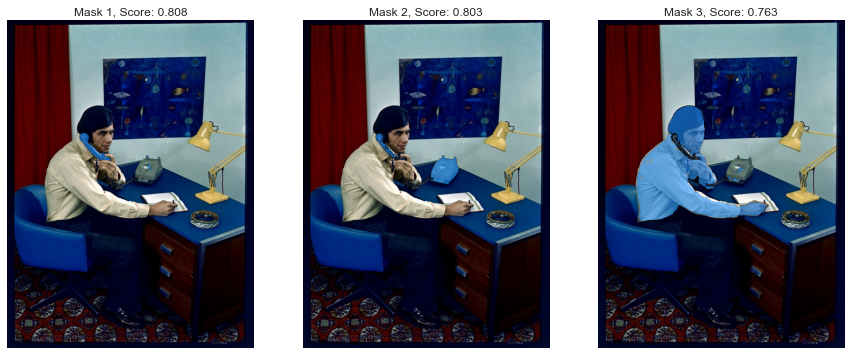

In [58]:
show_masks_on_image(raw_image, masks[0], scores)

In [60]:
last_mask = masks[0].squeeze(0)[1,:,:]

In [61]:
masked_image = np.copy(raw_image)

# Apply mask to each channel of the image
for i in range(3):  # assuming RGB image
    # Blank out pixels where mask is False
    masked_image[:, :, i] = np.where(last_mask[:, :] == False, 255, masked_image[:, :, i])


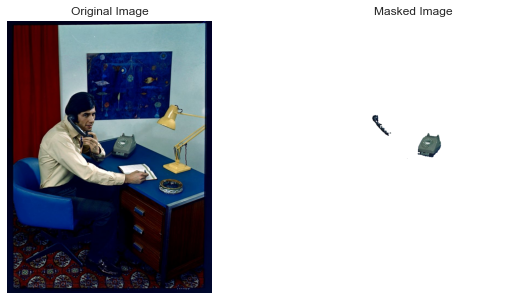

In [62]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.axis('off')

plt.show()

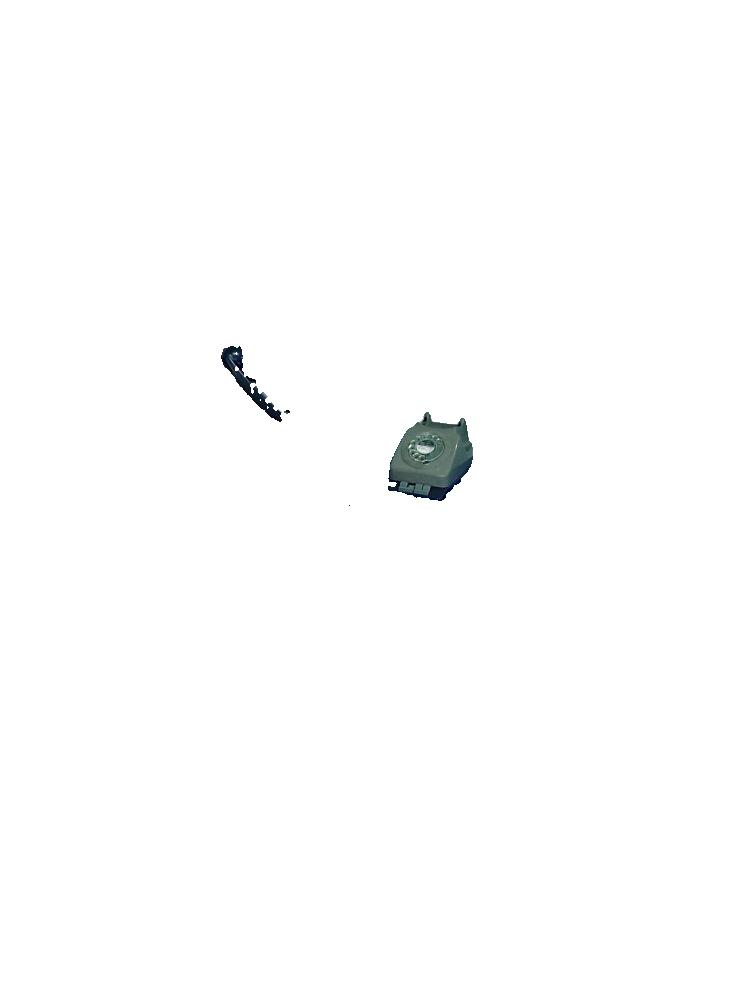

In [63]:
img = Image.fromarray(masked_image)
img.save('temp.jpg')
img = Image.open('temp.jpg')
img

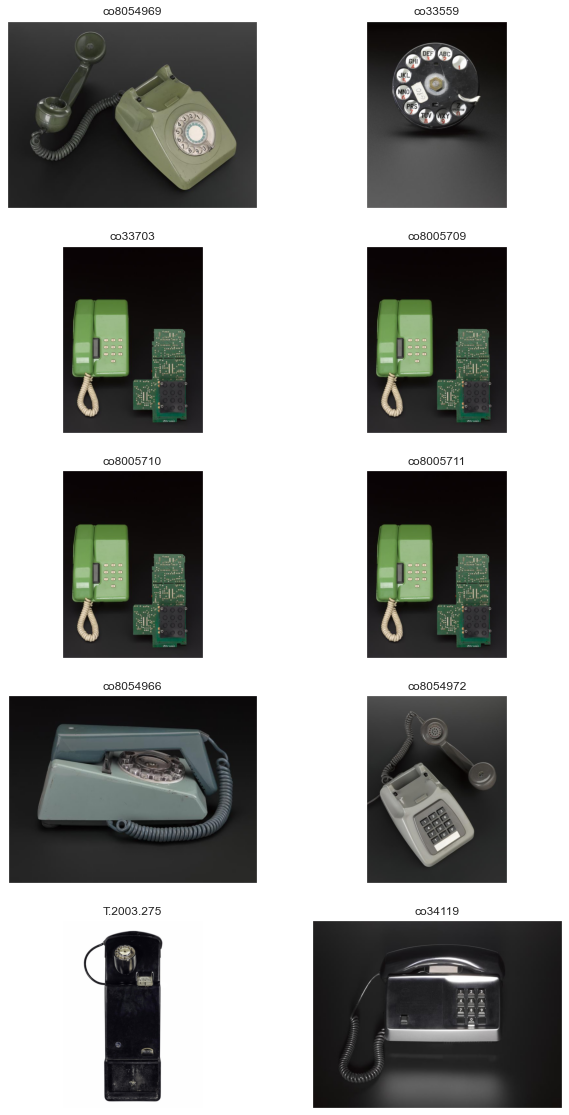

In [66]:

results = collection_db.query(query_images=[img],where={'input_modality':'image'},n_results=10) # 
query_df = plot_query_results(results, collection_df)